In [4]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(70%), Validation set(15%), and Test set(15%).

In [6]:
base_ds = '../input/rice-image-dataset/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [7]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 75000 files [07:30, 166.47 files/s]


In [18]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


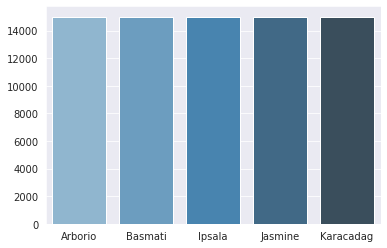

In [20]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (250, 250, 3)


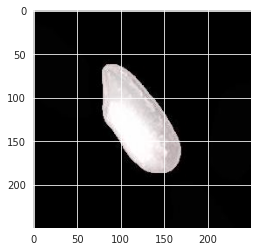

In [21]:
sample_img = cv2.imread('imgs/test/Arborio/Arborio (10).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [22]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

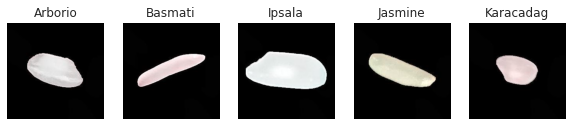

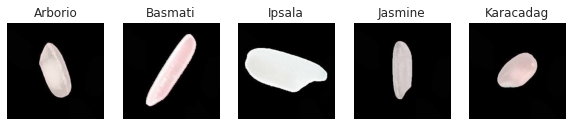

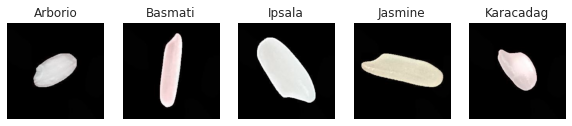

In [23]:
for i in range(3):
  load_random_img(base_ds, rice_classes)

In [24]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

### **Data Pre-processing**

In [25]:
datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [27]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## **Vanilla CNN Model**

In [28]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

2022-04-25 16:48:15.971937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 16:48:15.972875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 16:48:15.973662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 16:48:15.974603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 16:48:15.975350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [29]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 173, 173, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 173, 173, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 173, 173, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 173, 173, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 87, 87, 64)       

## **Callbacks**

In [30]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [31]:
history1 = model_vanilla.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

2022-04-25 16:48:16.779319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-25 16:48:18.812997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


411/411 [==============================] - 146s 334ms/step - loss: 0.1071 - accuracy: 0.9631 - val_loss: 4.2136 - val_accuracy: 0.5818

Epoch 00001: val_accuracy improved from -inf to 0.58178, saving model to saved_models/model_vanilla.hdf5
Epoch 2/40
411/411 [==============================] - 134s 327ms/step - loss: 0.0431 - accuracy: 0.9858 - val_loss: 122.6824 - val_accuracy: 0.4256

Epoch 00002: val_accuracy did not improve from 0.58178
Epoch 3/40
411/411 [==============================] - 134s 326ms/step - loss: 0.0336 - accuracy: 0.9891 - val_loss: 3.0265 - val_accuracy: 0.6121

Epoch 00003: val_accuracy improved from 0.58178 to 0.61209, saving model to saved_models/model_vanilla.hdf5
Epoch 4/40
411/411 [==============================] - 134s 325ms/step - loss: 0.0289 - accuracy: 0.9907 - val_loss: 0.9448 - val_accuracy: 0.9082

Epoch 00004: val_accuracy improved from 0.61209 to 0.90818, saving model to saved_models/model_vanilla.hdf5
Epoch 5/40
411/411 [=========================

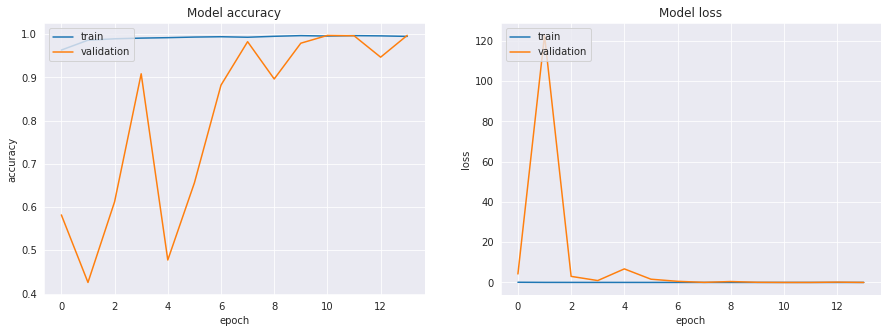

In [32]:
model_vanilla.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(history1)

## **Model Evaluation of Vanilla CNN**

In [33]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

88/88 [==============================] - 21s 235ms/step - loss: 0.0153 - accuracy: 0.9967


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)

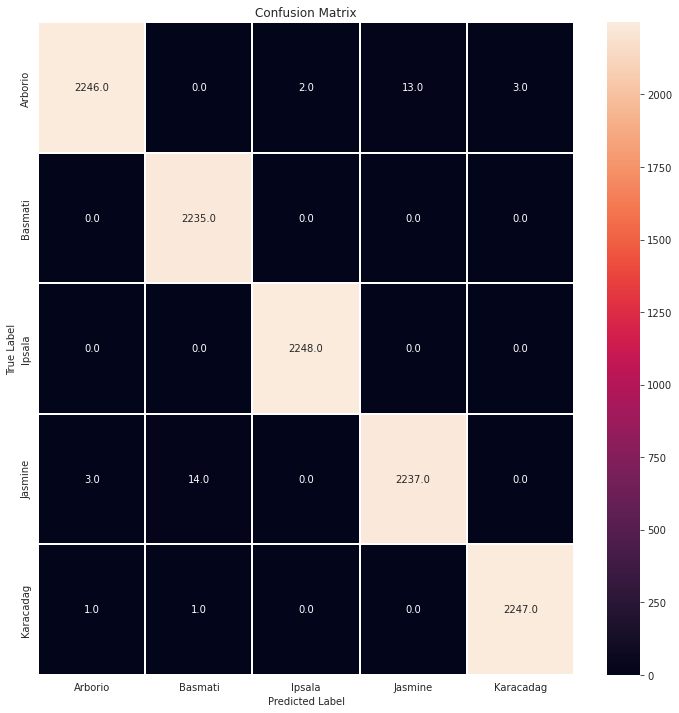

In [35]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [36]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.992049,0.998222,0.995126,2250.000000
Basmati,1.000000,0.993333,0.996656,2250.000000
Ipsala,1.000000,0.999111,0.999555,2250.000000
Jasmine,0.992458,0.994222,0.993339,2250.000000
Karacadag,0.999111,0.998667,0.998889,2250.000000
accuracy,0.996711,0.996711,0.996711,0.996711
macro avg,0.996724,0.996711,0.996713,11250.000000
weighted avg,0.996724,0.996711,0.996713,11250.000000


## **Transfer Learning**

In [37]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58900480/58889256 [==============================] - 0s 0us/step


In [38]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 175, 175, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 5125      
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [40]:
history2 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
411/411 [==============================] - 145s 337ms/step - loss: 0.1863 - accuracy: 0.9497 - val_loss: 0.0660 - val_accuracy: 0.9808

Epoch 00001: val_accuracy improved from -inf to 0.98080, saving model to saved_models/model_vgg16.hdf5
Epoch 2/40
411/411 [==============================] - 131s 317ms/step - loss: 0.0460 - accuracy: 0.9866 - val_loss: 0.0350 - val_accuracy: 0.9901

Epoch 00002: val_accuracy improved from 0.98080 to 0.99013, saving model to saved_models/model_vgg16.hdf5
Epoch 3/40
411/411 [==============================] - 131s 317ms/step - loss: 0.0376 - accuracy: 0.9878 - val_loss: 0.0359 - val_accuracy: 0.9894

Epoch 00003: val_accuracy did not improve from 0.99013
Epoch 4/40
411/411 [==============================] - 132s 320ms/step - loss: 0.0312 - accuracy: 0.9898 - val_loss: 0.0277 - val_accuracy: 0.9918

Epoch 00004: val_accuracy improved from 0.99013 to 0.99182, saving model to saved_models/model_vgg16.hdf5
Epoch 5/40
411/411 [======================

In [41]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

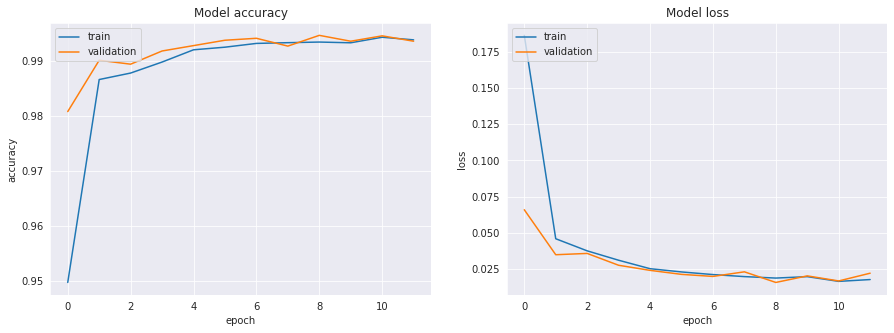

In [42]:
plot_train_history(history2)

In [43]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

88/88 [==============================] - 23s 264ms/step - loss: 0.0160 - accuracy: 0.9942
Model 1 Vanilla Loss: 0.01529560424387455, Accuracy: 99.67111349105835
Model 2 VGG16 Loss: 0.016011973842978477, Accuracy: 99.42222237586975


## **Fine Tuning**

In [54]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
history3 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
411/411 [==============================] - 229s 556ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.0125 - val_accuracy: 0.9971

Epoch 00001: val_accuracy did not improve from 0.99902
Epoch 2/40
411/411 [==============================] - 229s 556ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0081 - val_accuracy: 0.9980

Epoch 00002: val_accuracy did not improve from 0.99902
Epoch 3/40
411/411 [==============================] - 229s 557ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.0072 - val_accuracy: 0.9985

Epoch 00003: val_accuracy did not improve from 0.99902
Epoch 4/40
411/411 [==============================] - 229s 558ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0068 - val_accuracy: 0.9988

Epoch 00004: val_accuracy did not improve from 0.99902
Epoch 5/40
411/411 [==============================] - 228s 554ms/step - loss: 9.5336e-05 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9992

Epoch 00005: val_accuracy improved from 0

In [56]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

## **Final Evaluation**

In [57]:
score3 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')

88/88 [==============================] - 23s 258ms/step - loss: 0.0033 - accuracy: 0.9992
Model 1 Vanilla Loss: 0.01529560424387455, Accuracy: 99.67111349105835
Model 2 VGG16 Loss: 0.016011973842978477, Accuracy: 99.42222237586975
Model 2 VGG16 Fine-tuned Loss: 0.0032739941962063313, Accuracy: 99.91999864578247


In [58]:
Y_pred = model_vgg16.predict(test_ds)

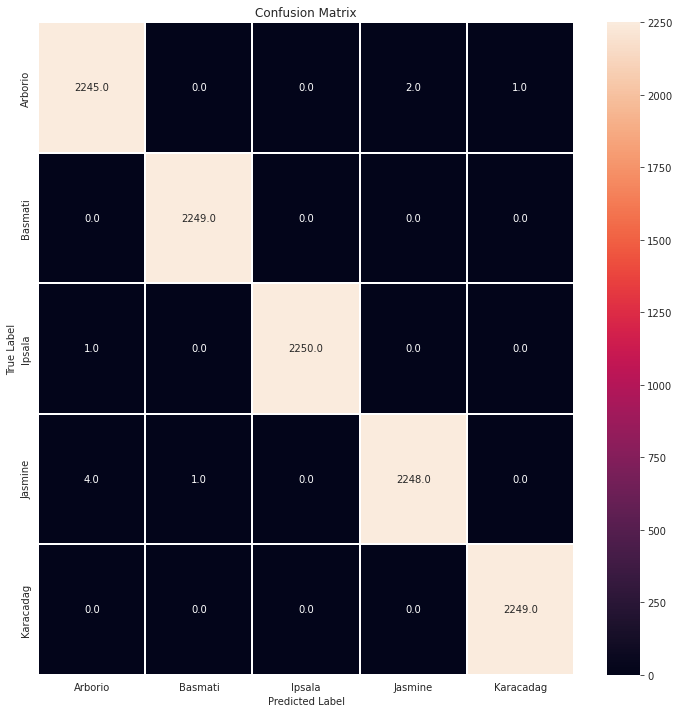

In [59]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [60]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report1).transpose()
df2

,precision,recall,f1-score,support
Arborio,0.992049,0.998222,0.995126,2250.000000
Basmati,1.000000,0.993333,0.996656,2250.000000
Ipsala,1.000000,0.999111,0.999555,2250.000000
Jasmine,0.992458,0.994222,0.993339,2250.000000
Karacadag,0.999111,0.998667,0.998889,2250.000000
accuracy,0.996711,0.996711,0.996711,0.996711
macro avg,0.996724,0.996711,0.996713,11250.000000
weighted avg,0.996724,0.996711,0.996713,11250.000000


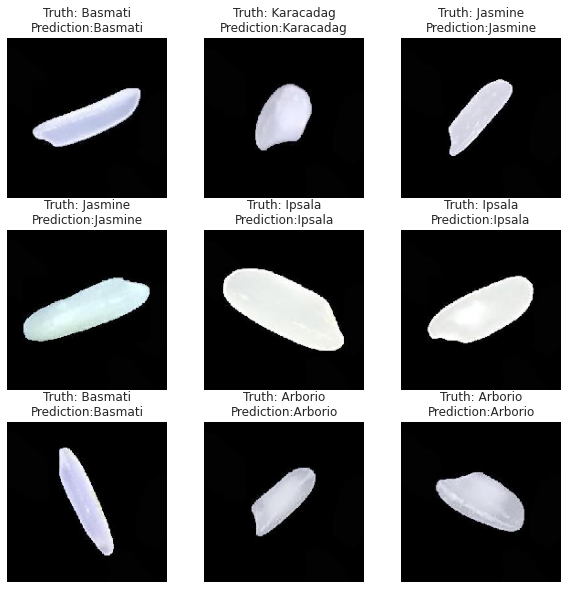

In [61]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)